## Pre-Process Data ##

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as sk
import sklearn.datasets
import sklearn.metrics
import os
from LinearRegression import LinearRegression
from sklearn.linear_model import LinearRegression as LR
from LogisticRegression import LogisticRegression
# from sklearn.linear_model import LogisticRegression
from MultiClassRegression import MultiClassRegression
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc

### Extact, Transform, Load (ETL) ###

In [29]:

def load_vocab(vocab_file_path):
    """
    Loads the vocabulary from a file and creates two dictionaries: 
    one mapping indices to words and another mapping words to indices.
    """
    index_to_feature_map = {}
    with open(vocab_file_path, 'r', encoding='utf-8') as vocab_file:
        for index, word in enumerate(vocab_file):
            index_to_feature_map[str(index)] = word.strip()
    feature_to_index_map = {word: index for index, word in index_to_feature_map.items()}
    return index_to_feature_map, feature_to_index_map

def parse_review_features(line):
    features = line.strip().split()[1:]  # Skip the first element (label)
    return [feature.split(':') for feature in features]

def compute_review_frequencies(feature_path):
    """
    Computes the frequency of each word across reviews.
    """
    review_frequencies = defaultdict(int)
    total_reviews = 0
    with open(feature_path, 'r', encoding='utf-8') as feat_file:
        for line in feat_file:
            total_reviews += 1
            for index, _ in parse_review_features(line):
                review_frequencies[index] += 1
    return review_frequencies, total_reviews

def filter_feature_indices(review_frequencies, total_reviews, lower_bound=0.01, upper_bound=0.5):
    """
    Filters out feature indices based on review frequency criteria.
    """
    min_reviews = total_reviews * lower_bound
    max_reviews = total_reviews * upper_bound
    filtered_feature_indices = {index for index, freq in review_frequencies.items() 
                                if min_reviews <= freq <= max_reviews}

    return sorted([int(i) for i in filtered_feature_indices])

def load_review_features(feature_path, index_mapping, n_reviews, n_features):
    """
    Loads review features and labels into matrices based on a filtered and remapped vocabulary.
    """
    X = np.zeros((n_reviews, n_features))
    y = np.zeros(n_reviews)
    with open(feature_path, 'r') as file:
        for review_id, line in enumerate(file):
            parts = line.strip().split()
            y[review_id] = int(parts[0])  # First part is the label
            for index, count in parse_review_features(line):
                if index in index_mapping:
                    X[review_id, index_mapping[index]] = int(count)
    return X, y

def filter_by_regression_coefficients(X, y, D=1000):
    model = LinearRegression()
    model.fit(X, y)
    coefficients = model.w[:-1]
    top_indices = np.argsort(np.abs(coefficients))[-D:]
    return top_indices, coefficients

# Evaluation and Plotting Functions #

### Evaluation Functions ###

In [30]:

def evaluate_multiclass_classification(df):
    """
    compute classification accuracy
    """
    pass


### Plotting Functions ###

In [31]:

def plot_top_features(coefficients, sorted_indices, index_to_feature_map, reverse_index_mapping, n_features=10):
    """
    Plots the top N negative and positive features based on their coefficients, with a legend.
    
    Parameters:
    - coefficients: Array of feature coefficients from a regression model.
    - index_to_feature_map: Dictionary mapping original feature indices to words.
    - reverse_index_mapping: Dictionary mapping from reduced feature space to original index.
    - n_features: Number of top features to plot for both negative and positive coefficients.
    """
    
    # Separate positive and negative coefficients
    positive_indices = [i for i, coef in enumerate(coefficients) if coef > 0]
    negative_indices = [i for i, coef in enumerate(coefficients) if coef < 0]
    
    # Sort them by absolute values but keep the sign for color coding
    top_positive_indices = sorted(positive_indices, key=lambda i: coefficients[i], reverse=True)[:n_features]
    top_negative_indices = sorted(negative_indices, key=lambda i: coefficients[i])[:n_features]
    
    # Combine the indices and coefficients for plotting
    top_indices = top_negative_indices + top_positive_indices
    top_coefficients = [coefficients[i] for i in top_indices]
    top_words = [index_to_feature_map[str(reverse_index_mapping[i])] for i in top_indices]
    
    # Determine colors based on coefficient sign
    colors = ['red' if coef < 0 else 'blue' for coef in top_coefficients]
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x=np.abs(top_coefficients), y=top_words, palette=colors, orient='h')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.title('Top 20 Features by Absolute Coefficient Value From Linear Regression')
    
    # Create a custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='blue', edgecolor='blue', label='Positive'),
                       Patch(facecolor='red', edgecolor='red', label='Negative')]
    plt.legend(handles=legend_elements, title='Coefficient Sign')
    plt.savefig('top_20_features.png')
    plt.show()

In [32]:
def plot_training_progress(logistic_regression_model):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(logistic_regression_model.loss_history, label='Loss', color='b', ls='-',linewidth=1)
    plt.title('Loss Progress over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(logistic_regression_model.gradient_norm_history, label='Gradient Norm')
    plt.title('Gradient Norm Progress over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_binary_classification(results):
    """
    plot ROC curve
    compare to DT from sklearn
    
    Args:
    - results: tuple of fpr, tpr, auroc
    
    Return:
    - None, plot the ROC curve
    
    """
    fpr, tpr, auroc = results
    print(f"Area under the ROC curve: {auroc}")
    print(f"True positive rate: {tpr}")
    print(f"False positive rate: {fpr}")
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auroc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_roc_curves(results_train, results_test, additional_results=None):
    """
    Plot ROC curves for training and test datasets, and optionally for an additional classifier.
    
    Args:
    - results_train: tuple of (fpr, tpr, auroc) for the training set.
    - results_test: tuple of (fpr, tpr, auroc) for the test set.
    - additional_results: tuple of (fpr, tpr, auroc) for an additional classifier, optional.
    
    Return:
    - None, plot the ROC curves.
    """
    plt.figure(figsize=(10, 8))
    
    # Plot training ROC
    fpr, tpr, auroc = results_train
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Train ROC curve (area = {auroc:.2f})')
    
    # Plot test ROC
    fpr, tpr, auroc = results_test
    plt.plot(fpr, tpr, color='green', lw=2, label=f'Test ROC curve (area = {auroc:.2f})')
    
    # Optionally plot additional classifier ROC
    if additional_results:
        fpr, tpr, auroc = additional_results
        plt.plot(fpr, tpr, color='red', lw=2, label=f'Additional ROC curve (area = {auroc:.2f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_multiclass_classification(results):
    """
    compare accuracy to DT from sklearn
    
    """
    pass

def plot_top_20_features_from_imdb_simple(top_positive_features, top_negative_features):
    """
    A horizontal bar plot showing the top 20 features from the Simple linear regression on the IMDB data
    
    Characteristics:
    - 10 most positive and negative coefficients as the x-axis 
    - Feature names (i.e., words) as the y-axis  
    """
    # Plot the top 20 positive and negative features on the same plot
    plt.figure(figsize=(10, 10))
    # assign each a different color and make negatives positive
    top_negative_features['Impact'] = top_negative_features['Impact'].abs()
    plt.barh(top_positive_features['Word'].head(10), top_positive_features['Impact'].head(10), color='b', label='Positive Impact')
    plt.barh(top_negative_features['Word'].head(10), top_negative_features['Impact'].head(10), color='r', label='Negative Impact')
    plt.xlabel('Regression Coefficients (Absolute Value)')
    plt.ylabel('Word')
    plt.title('Top 20 Features from Simple Linear Regression')
    plt.legend()
    #plt.savefig('top_20_features_from_imdb_simple.png')
    plt.show()
    
    
def plot_model_convergence(results, learning_rate):
    """
    Convergence plot on how the logistic and multiclass regression converge given a reason- ably chosen learning rate.
    """
    pass

def plot_imdb_data_roc_curve(results):
    """
    A single plot containing two ROC curves of logistic regression and sklearn-DT (Decision Trees) on the IMDB test data.
    """
    pass

def plot_imdb_data_auroc(results):
    """
    A bar plot that shows the AUROC of logistic regression and DT on the test data (y-axis) 
    as a function of the 20%, 40%, 60%, 80%, and 100% training data (x-axis)
    """
    pass

def plot_news_data_classification_accuracy(results):
    """
    A bar plot that shows the classification accuracies of multiclass regression and DT 
    on the test data (y-axis) as a function of the 20%, 40%, 60%, 80%, and 100% training data (x- axis)
    """
    pass

def plot_top_20_features_from_imdb_logistic(results):
    """
    A horizontal bar plot showing the top 20 features (10 most positive and 10 most negative) 
    from the logistic regression on the IMDB data with the coefficient as the x-axis and the feature names (i.e., words) as the y-axis
    """
    pass

def plot_heatmap_of_multi_classification(results):
    """
    A heatmap showing the top 5 most positive features as rows for each class as columns in the multi-class classification 
    on 4 the chosen classes from the 20-news group datasets. Therefore, your heatmap should be a 20-by-4 dimension.

    """
    pass

# Experiments #

In [33]:
# Driver code to load everything

# Define globals
VOCAB_FILE = '../aclImdb/imdb.vocab'
TRAIN_FEAT = '../aclImdb/train/labeledBow.feat'
TEST_FEAT = '../aclImdb/test/labeledBow.feat'
N_REVIEWS = 25000

# load the data and filter the reviews
index_to_feature_map, feature_to_index_map = load_vocab(VOCAB_FILE)
review_frequencies, total_reviews = compute_review_frequencies(TRAIN_FEAT)
filtered_indices = filter_feature_indices(review_frequencies, total_reviews)
index_mapping = {str(old_index): new_index for new_index, old_index in enumerate(filtered_indices)}

# create train and test based on the filtered indices
N_FEATURES = len(filtered_indices)
X_train, y_train = load_review_features(TRAIN_FEAT, index_mapping, N_REVIEWS, N_FEATURES)
X_test, y_test = load_review_features(TEST_FEAT, index_mapping, N_REVIEWS, N_FEATURES)

# Now filter by the regression coefficients
top_indices, coefficients = filter_by_regression_coefficients(X_train, y_train)
reverse_index_mapping = {new_index: old_index for old_index, new_index in index_mapping.items()}

### Experiment 1 ###

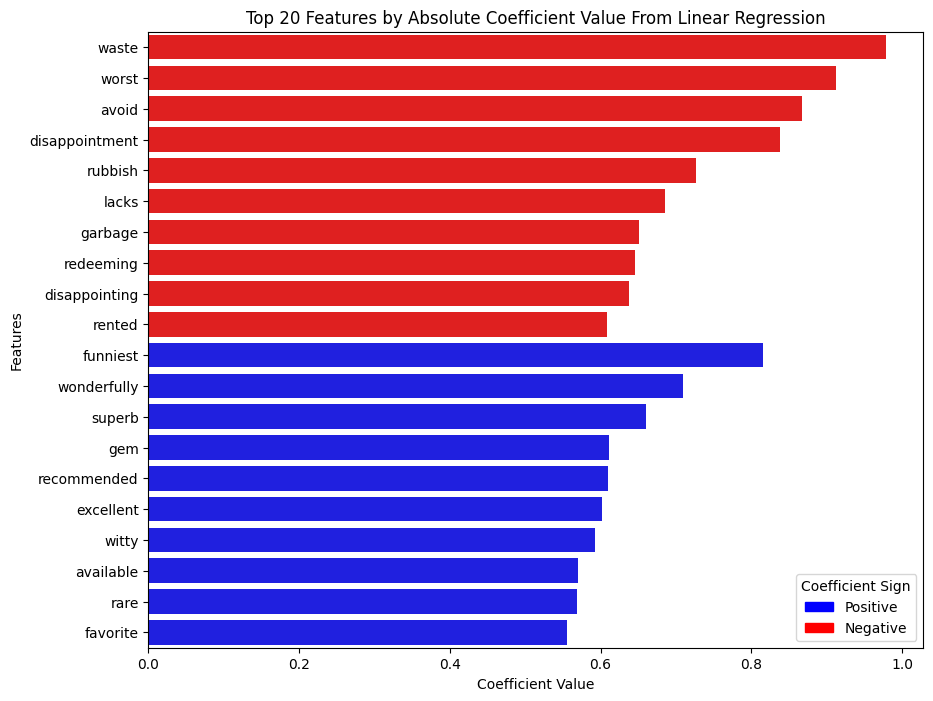

In [34]:
def experiment_one():
    """
    Report the:
    - top 10 features with the most positive coefficients
    - top 10 features with the most negative coefficients 
    
    on the IMDB data using simple linear regression on the movie rating scores
    """
    plot_top_features(coefficients, top_indices[::-1], index_to_feature_map, reverse_index_mapping ,n_features=10)
    
experiment_one()

### Experiment 2 ###

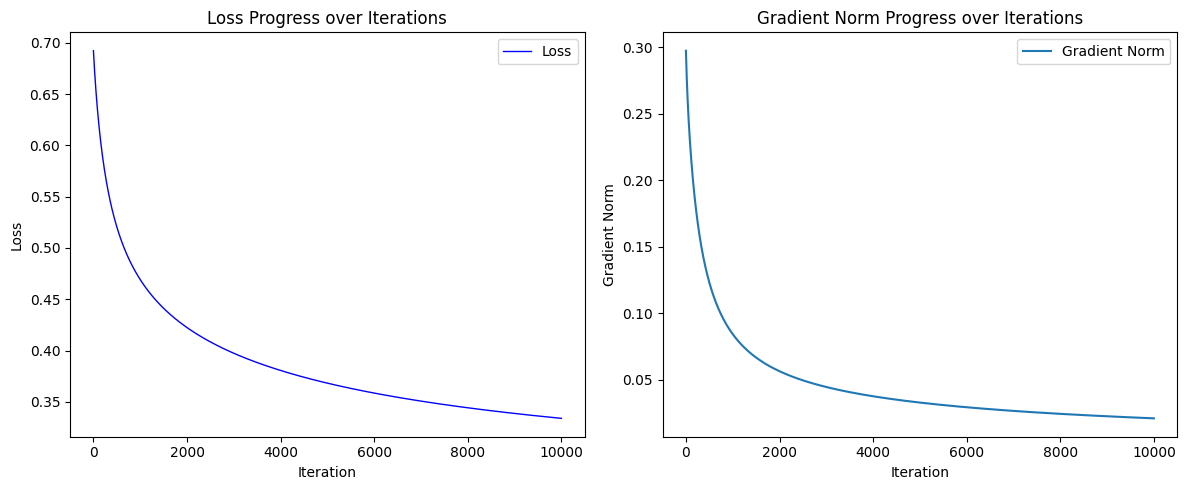

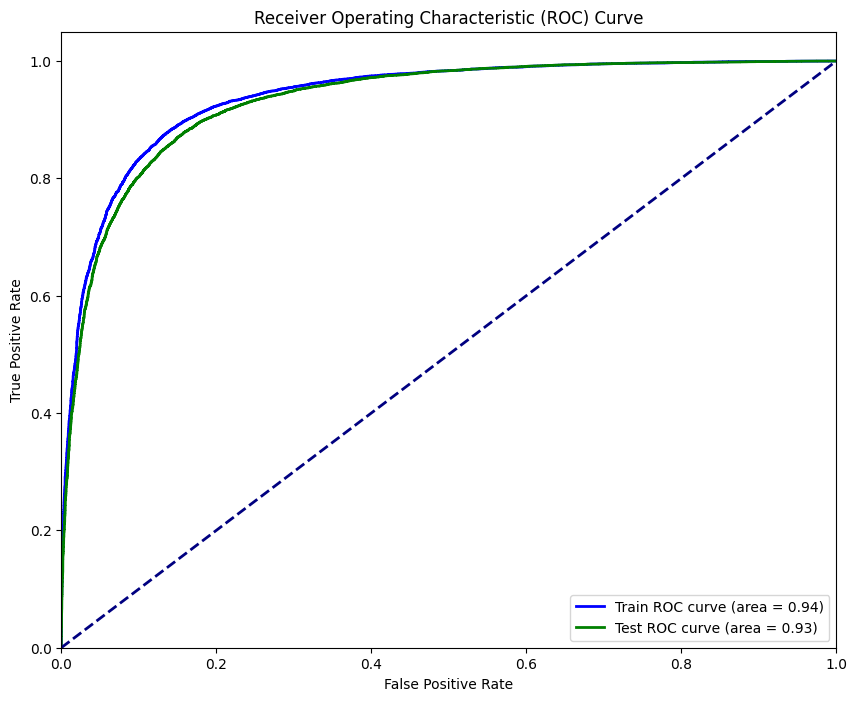

In [42]:
def experiment_two(X_train, y_train, X_test, y_test, top_indices):
    """
    Implement and conduct:
    - Binary classification on the IMDb Reviews
    - Multi-class classification on the 20 news group dataset
    """
    # Convert y_train and y_test to binary
    y_train_binary = (y_train > 5).astype(int)
    y_test_binary = (y_test > 5).astype(int)
    
    # Filter features based on top_indices
    X_train_filtered = X_train[:, top_indices]
    X_test_filtered = X_test[:, top_indices]
    
    model = LogisticRegression(learning_rate=0.01, epsilon=1e-5, max_iters=1e4)
    model.fit(X_train_filtered, y_train_binary)
    plot_training_progress(model)
    y_pred_prob_test = model.predict(X_test_filtered)
    y_pred_prob_train = model.predict(X_train_filtered)
    
    # Compute ROC curve and ROC area for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test_binary, y_pred_prob_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # Compute ROC curve and ROC area for the training set
    fpr_train, tpr_train, _ = roc_curve(y_train_binary, y_pred_prob_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    plot_roc_curves((fpr_train, tpr_train, roc_auc_train), (fpr_test, tpr_test, roc_auc_test))
    
experiment_two(X_train, y_train, X_test, y_test, top_indices)

### Experiment 3 ###

In [36]:
def experiment_three():
    """
    On the same plot as 2, draw ROC curves and report the AUROC 
    values of logistic regression and Decision Trees on the 
    IMDB data binary classification task
    
    """
    pass

### Experiment 4 ###

In [37]:
def experiment_four():
    """
    Report the:
    - Multiclass classification accuracy of multiclass linear regression 
    - Decision Trees on the 5 chosen classes from the 20-news-group data
    """
    pass

### Experiment 5 ###

In [38]:
def experiment_five():
    """
    Plot and compare the accuracy of the two models as a function of the
    size of dataset by controlling the training size
    
    For example, you can randomly select 20%, 40%, 60% and 80% of the available 
    training data and train your model on this subset and evaluate the trained 
    model on the held-out test set.
    """
    pass

### Experiment 6 ###

In [39]:
def experiment_six():
    """
    Compare and evaluate the performance of different learning rates
    """
    pass

### Experiment 7 ###

In [40]:
def experiment_seven():
    """
    Evaluate the performance of the multiclass regression on more than 5 classes
    
    Compare the top k (e.g. k =3) predicted classes. 
    A correct prediction is determined by whether the true label is within the top k predicted labels. 
    The scoring mechanism involves assigning a score of 1 if the correct label is among the top k predictions and 0 otherwise.
    """
    pass